Продолжение ноутбука uplift_model2

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.model_selection import train_test_split


import json
import logging
from math import ceil
import time



# !pip install -q psycopg2-binary pandas
import psycopg2 as pg
from getpass import getpass
from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)



Дальше будет представлено обучение BCAUSS модели с различными тритментами. Набор признаков для обучения одинаковый в каждом случае (все признаки, кроме treatment).

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


In [18]:
def make_bcauss(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # Representation Layer
    x = layers.Dense(200, activation='relu')(inputs)
    x = layers.Dense(200, activation='relu')(x)
    representation = layers.Dense(100, activation='relu', name='representation')(x)

    # y0 head
    y0_hidden = layers.Dense(100, activation='relu')(representation)
    y0_pred = layers.Dense(1, name='y0')(y0_hidden)

    # y1 head
    y1_hidden = layers.Dense(100, activation='relu')(representation)
    y1_pred = layers.Dense(1, name='y1')(y1_hidden)

    return Model(inputs=inputs, outputs=[y0_pred, y1_pred, representation])


In [19]:
def bcauss_loss(y_true, t_true, y0_pred, y1_pred, rep, alpha=1.0):
    # Предсказание y
    y_pred = t_true * tf.squeeze(y1_pred) + (1 - t_true) * tf.squeeze(y0_pred)
    loss_y = tf.reduce_mean(tf.square(y_true - y_pred))

    # Преобразование t_true к вектору
    t_true_flat = tf.reshape(t_true, [-1])

    # Разделение представлений
    rep_treated = tf.boolean_mask(rep, tf.equal(t_true_flat, 1))
    rep_control = tf.boolean_mask(rep, tf.equal(t_true_flat, 0))

    # Корректное сравнение распределений
    def cosine_dist(a, b):
        a = tf.math.l2_normalize(a, axis=1)
        b = tf.math.l2_normalize(b, axis=1)
        sim_matrix = tf.matmul(a, b, transpose_b=True)  # shape: [n_a, n_b]
        return tf.reduce_mean(1 - sim_matrix)

    if tf.shape(rep_treated)[0] > 0 and tf.shape(rep_control)[0] > 0:
        loss_balance = cosine_dist(rep_treated, rep_control)
    else:
        loss_balance = 0.0

    return loss_y + alpha * loss_balance, loss_y, loss_balance


Модель 1

In [62]:
input_dim = X_train_scaled.shape[1]
model = make_bcauss(input_dim)
optimizer = Adam(learning_rate=1e-3)

EPOCHS = 100
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled.astype('float32'),
     y_train_scaled.astype('float32'),
     treat_train.astype('float32'))
).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss, epoch_y, epoch_balance = 0.0, 0.0, 0.0
    for x_batch, y_batch, t_batch in train_dataset:
        with tf.GradientTape() as tape:
            y0_pred, y1_pred, rep = model(x_batch, training=True)
            loss, loss_y, loss_bal = bcauss_loss(y_batch, t_batch, y0_pred, y1_pred, rep)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss.numpy()
        epoch_y += loss_y.numpy()
        epoch_balance += loss_bal.numpy()
    
    print(f"Epoch {epoch+1}: Total Loss={epoch_loss:.4f}, Y Loss={epoch_y:.4f}, Balance Loss={epoch_balance:.4f}")


Epoch 1: Total Loss=38.2230, Y Loss=35.5048, Balance Loss=2.7182
Epoch 2: Total Loss=34.6769, Y Loss=33.7187, Balance Loss=0.9582
Epoch 3: Total Loss=34.5038, Y Loss=33.7325, Balance Loss=0.7713
Epoch 4: Total Loss=29.9508, Y Loss=29.3240, Balance Loss=0.6268
Epoch 5: Total Loss=32.9607, Y Loss=32.5326, Balance Loss=0.4281
Epoch 6: Total Loss=24.6583, Y Loss=23.5275, Balance Loss=1.1307
Epoch 7: Total Loss=11.3594, Y Loss=10.7746, Balance Loss=0.5849
Epoch 8: Total Loss=5.8649, Y Loss=5.5889, Balance Loss=0.2761
Epoch 9: Total Loss=3.1985, Y Loss=2.9913, Balance Loss=0.2072
Epoch 10: Total Loss=10.0654, Y Loss=9.7679, Balance Loss=0.2975
Epoch 11: Total Loss=20.3999, Y Loss=20.2183, Balance Loss=0.1817
Epoch 12: Total Loss=17.0998, Y Loss=16.9209, Balance Loss=0.1789
Epoch 13: Total Loss=16.7148, Y Loss=16.5130, Balance Loss=0.2018
Epoch 14: Total Loss=16.6822, Y Loss=16.4821, Balance Loss=0.2001
Epoch 15: Total Loss=12.7992, Y Loss=12.5761, Balance Loss=0.2231
Epoch 16: Total Loss=9.0

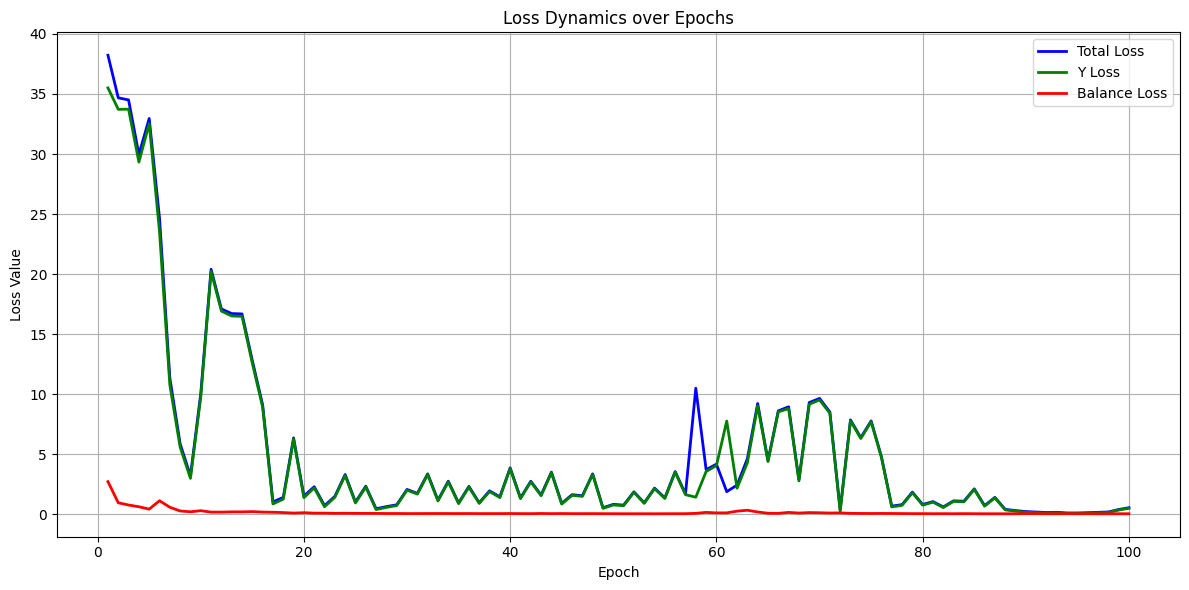

In [63]:

plt.figure(figsize=(12, 6))
plt.plot(epochs, total_loss, label="Total Loss", color="blue", linewidth=2)
plt.plot(epochs, y_loss, label="Y Loss", color="green", linewidth=2)
plt.plot(epochs, balance_loss, label="Balance Loss", color="red", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Dynamics over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
model.save('bcauss_model.keras')

Модель 2

In [55]:
input_dim = X_train_scaled.shape[1]
model = make_bcauss(input_dim)
optimizer = Adam(learning_rate=1e-3)

EPOCHS = 100
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled.astype('float32'),
     y_train_scaled.astype('float32'),
     treat_train.astype('float32'))
).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss, epoch_y, epoch_balance = 0.0, 0.0, 0.0
    for x_batch, y_batch, t_batch in train_dataset:
        with tf.GradientTape() as tape:
            y0_pred, y1_pred, rep = model(x_batch, training=True)
            loss, loss_y, loss_bal = bcauss_loss(y_batch, t_batch, y0_pred, y1_pred, rep)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Суммируем значения (независимо от типа: float или tf.Tensor)
        epoch_loss += float(loss)
        epoch_y += float(loss_y)
        epoch_balance += float(loss_bal)
    
    print(f"Epoch {epoch+1}: Total Loss={epoch_loss:.4f}, Y Loss={epoch_y:.4f}, Balance Loss={epoch_balance:.4f}")


Epoch 1: Total Loss=38.2230, Y Loss=35.5048, Balance Loss=2.7182
Epoch 2: Total Loss=34.6769, Y Loss=33.7187, Balance Loss=0.9582
Epoch 3: Total Loss=34.5038, Y Loss=33.7325, Balance Loss=0.7713
Epoch 4: Total Loss=29.9508, Y Loss=29.3240, Balance Loss=0.6268
Epoch 5: Total Loss=32.9607, Y Loss=32.5326, Balance Loss=0.4281
Epoch 6: Total Loss=24.6583, Y Loss=23.5275, Balance Loss=1.1307
Epoch 7: Total Loss=31.3594, Y Loss=10.7746, Balance Loss=0.5849
Epoch 8: Total Loss=35.8649, Y Loss=15.5889, Balance Loss=0.2761
Epoch 9: Total Loss=33.1985, Y Loss=12.9913, Balance Loss=0.2072
Epoch 10: Total Loss=30.0654, Y Loss=19.7679, Balance Loss=0.2975
Epoch 11: Total Loss=30.3999, Y Loss=20.2183, Balance Loss=0.1817
Epoch 12: Total Loss=37.0998, Y Loss=16.9209, Balance Loss=0.1789
Epoch 13: Total Loss=36.7148, Y Loss=16.5130, Balance Loss=0.2018
Epoch 14: Total Loss=36.6822, Y Loss=16.4821, Balance Loss=0.2001
Epoch 15: Total Loss=32.7992, Y Loss=12.5761, Balance Loss=0.2231
Epoch 16: Total Los

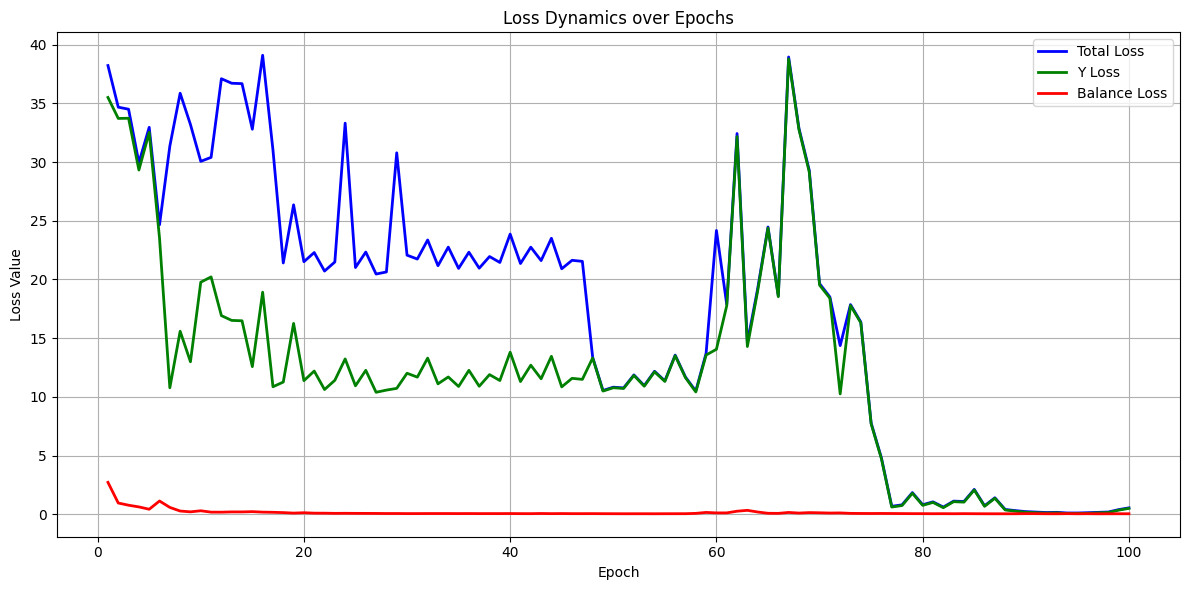

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, total_loss, label="Total Loss", color="blue", linewidth=2)
plt.plot(epochs, y_loss, label="Y Loss", color="green", linewidth=2)
plt.plot(epochs, balance_loss, label="Balance Loss", color="red", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Dynamics over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
model.save('bcauss_model2.keras')

Модель 3

In [67]:
input_dim = X_train_scaled.shape[1]
model = make_bcauss(input_dim)
optimizer = Adam(learning_rate=1e-3)

EPOCHS = 100
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled.astype('float32'),
     y_train_scaled.astype('float32'),
     treat_train.astype('float32'))
).shuffle(1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss, epoch_y, epoch_balance = 0.0, 0.0, 0.0
    for x_batch, y_batch, t_batch in train_dataset:
        with tf.GradientTape() as tape:
            y0_pred, y1_pred, rep = model(x_batch, training=True)
            loss, loss_y, loss_bal = bcauss_loss(y_batch, t_batch, y0_pred, y1_pred, rep)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Суммируем значения (независимо от типа: float или tf.Tensor)
        epoch_loss += float(loss)
        epoch_y += float(loss_y)
        epoch_balance += float(loss_bal)
    
    print(f"Epoch {epoch+1}: Total Loss={epoch_loss:.4f}, Y Loss={epoch_y:.4f}, Balance Loss={epoch_balance:.4f}")


Epoch 1: Total Loss=38.2230, Y Loss=35.5048, Balance Loss=2.7182
Epoch 2: Total Loss=34.6769, Y Loss=33.7187, Balance Loss=0.9582
Epoch 3: Total Loss=34.5038, Y Loss=33.7325, Balance Loss=0.7713
Epoch 4: Total Loss=29.9508, Y Loss=29.3240, Balance Loss=0.6268
Epoch 5: Total Loss=32.9607, Y Loss=32.5326, Balance Loss=0.4281
Epoch 6: Total Loss=24.6583, Y Loss=23.5275, Balance Loss=1.1307
Epoch 7: Total Loss=31.3594, Y Loss=10.7746, Balance Loss=0.5849
Epoch 8: Total Loss=35.8649, Y Loss=15.5889, Balance Loss=0.2761
Epoch 9: Total Loss=33.1985, Y Loss=12.9913, Balance Loss=0.2072
Epoch 10: Total Loss=30.0654, Y Loss=19.7679, Balance Loss=0.2975
Epoch 11: Total Loss=30.3999, Y Loss=20.2183, Balance Loss=0.1817
Epoch 12: Total Loss=37.0998, Y Loss=16.9209, Balance Loss=0.1789
Epoch 13: Total Loss=36.7148, Y Loss=16.5130, Balance Loss=0.2018
Epoch 14: Total Loss=36.6822, Y Loss=16.4821, Balance Loss=0.2001
Epoch 15: Total Loss=32.7992, Y Loss=12.5761, Balance Loss=0.2231
Epoch 16: Total Los

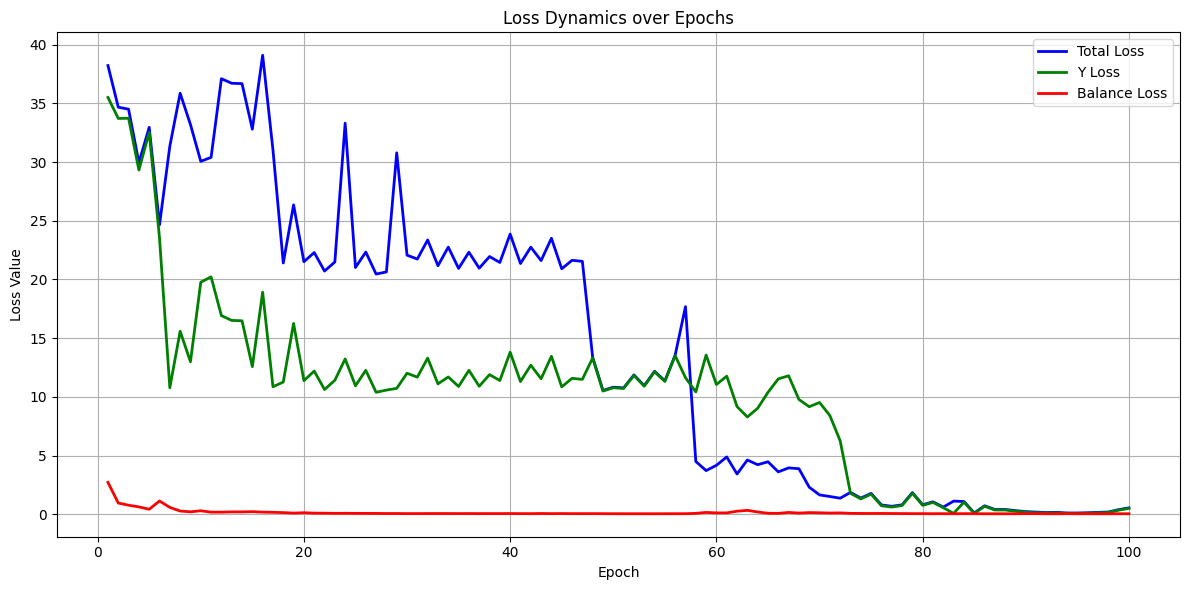

In [69]:
# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(epochs, total_loss, label="Total Loss", color="blue", linewidth=2)
plt.plot(epochs, y_loss, label="Y Loss", color="green", linewidth=2)
plt.plot(epochs, balance_loss, label="Balance Loss", color="red", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Dynamics over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
model.save('bcauss_model3.keras')

Сравнение качества моделей

In [ ]:
models_results = {
    'model': ['BCAUSS1', 'BCAUSS2', 'BCAUSS3', 'BCAUSS4'],
    'uplift@30%': [],
    'AUQC': [],
    'AUUC': []
}






models_results['uplift@30%'].append(
    0.085673
)
models_results['AUQC'].append(
    0.082213
)
models_results['AUUC'].append(
    0.115523
)


models_results['uplift@30%'].append(
    0.081641
)

models_results['AUQC'].append(
    0.081334
)
models_results['AUUC'].append(
    0.094534
)



models_results['uplift@30%'].append(
    0.079472
)

models_results['AUQC'].append(
    0.071236
)
models_results['AUUC'].append(
    0.094545
)


pd.DataFrame(data=models_results).sort_values('AUUC', ascending=False)